# Text Generation with Transformers

In this notebook we use the components developed in `modelling.transformer` to train a transformer decoder for our text generation task. We will compare the performance of this model with that established by our RNN baseline.

## Imports

The bulk of the code required to setup, train and generate new text from the model, is contained within `modelling.transformer` (check the source code for the details). We import this module together with others that serve the training data and manage model persistence.

In [1]:
import warnings

from torch import device
from torch.utils.data import DataLoader

from modelling import data as data
from modelling import transformer as tfr
from modelling import utils as utils

warnings.filterwarnings("ignore")

## Model and Training Parameters

Configure hyper-parameters for the model and the training routine.

In [2]:
MODEL_NAME = "decoder_next_word_gen"

SIZE_EMBED = 256

MAX_EPOCHS = 30
BATCH_SIZE = 64
SEQ_LEN = 60
MIN_WORD_FREQ = 2
MAX_LEARNING_RATE = 0.001
WARMUP_EPOCHS = 2
GRADIENT_CLIP = 5

DEVICE = device("cpu")

Note that we have explicitly chosen to train this model on the CPU as the MPS backend (for Apple silicon) doesn't (yet) have support for all the calculations required by multi-head attention. Consequently, it has to fall back on the CPU for some calculations and this constant back-and-forth results in significantly longer training times.

## Setup Training Data

In [3]:
datasets = data.make_sequence_datasets(seq_len=SEQ_LEN, min_freq=MIN_WORD_FREQ)

train_dl = DataLoader(
    datasets.train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

val_dl = DataLoader(
    datasets.val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    collate_fn=data.pad_seq2seq_data,
)

## Instantiate Model

In [4]:
model = tfr.NextWordPredictionTransformer(datasets.tokenizer.vocab_size, SIZE_EMBED)
model

NextWordPredictionTransformer(
  (_position_encoder): PositionalEncoding(
    (_dropout): Dropout(p=0.1, inplace=False)
  )
  (_embedding): Embedding(30050, 256)
  (_decoder): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=Fal

If we compare this model with the RNN model, then it is easy to see that this one is significantly more complex with many more layers (and thus parameters). We start with the same embedding layer albeit combined with a positional encoding, that is then fed into a transformer decoder layer comprised of two multi-head attention blocks, two linear (dense) feed-forward layers and three sets of layer normalisation and dropout.

## Train

As well as having a far more complex architecture, transformer based models are also trickier to train successfully. In particular, the vast number of parameters can lead to gradients that can grow very large in the early stages of training, thus preventing convergence.

We handle this using a learning rate schedule that starts close to zero and slowly ramps-up, before falling again as we reach the end of the desired number of epochs. We also clip the gradients - see the source code for the full details.

In [5]:
train_losses, val_losses, cp = tfr.train(
    model,
    train_dl,
    val_dl,
    MAX_EPOCHS,
    MAX_LEARNING_RATE,
    WARMUP_EPOCHS,
    GRADIENT_CLIP,
    device=DEVICE,
)
utils.save_model(model, name=MODEL_NAME, loss=min(val_losses.values()))

number of warmup steps: 1334 / 20010


epoch 9 training loss = 4.6933 (LR = 0.00079389): 100%|██████████| 667/667 [08:48<00:00,  1.26it/s]
epoch 10 training loss = 4.6470 (LR = 0.00075000): 100%|██████████| 667/667 [08:48<00:00,  1.26it/s]
epoch 11 training loss = 4.6077 (LR = 0.00070337): 100%|██████████| 667/667 [08:49<00:00,  1.26it/s]
epoch 12 training loss = 4.5743 (LR = 0.00065451): 100%|██████████| 667/667 [08:47<00:00,  1.26it/s]
epoch 13 training loss = 4.5377 (LR = 0.00060396): 100%|██████████| 667/667 [08:49<00:00,  1.26it/s]
epoch 14 training loss = 4.5067 (LR = 0.00055226): 100%|██████████| 667/667 [08:49<00:00,  1.26it/s]
epoch 15 training loss = 4.4767 (LR = 0.00050000): 100%|██████████| 667/667 [08:48<00:00,  1.26it/s]
epoch 16 training loss = 4.4478 (LR = 0.00044774): 100%|██████████| 667/667 [08:48<00:00,  1.26it/s]
epoch 17 training loss = 4.4203 (LR = 0.00039604): 100%|██████████| 667/667 [08:49<00:00,  1.26it/s]
epoch 18 training loss = 4.3959 (LR = 0.00034549): 100%|██████████| 667/667 [08:49<00:00,  1


best model:
|-- epoch: 19
|-- loss: 4.7688


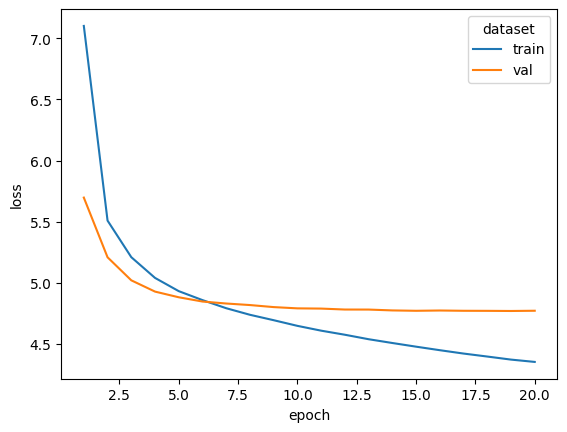

In [6]:
utils.plot_train_losses(train_losses, val_losses)

## Generate Text with Model

Start by loading a model and instantiating a tokenizer that can also map from tokens back to text. The `load_model` function will load the best performing model that has been persisted on the local filesystem.

In [4]:
best_model: tfr.NextWordPredictionTransformer = utils.load_model(MODEL_NAME)

loading .models/decoder_next_word_gen/trained@2023-07-15T17:31:36;loss=4_7688.pt


Then set a prompt.

In [10]:
prompt = "Now I love horror, but I found this"

### Greedy Decoding Strategy

Pass a prompt to the model and use a greedy decoding strategy to generate new text.Now pass a prompt to the model and get it to generate the text that comes after.

In [11]:
text = tfr.generate(best_model, prompt, datasets.tokenizer, "greedy", temperature=1.0)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS movie to be a little more than a little bit of a
bit of a bit of a bit of a bit of a bit of a bit of a bit of a bit of a bit too much. The
plot is too predictable and the ending is very abrupt and the ending. The ending. The
ending...


### Top-k Decoding Strategy

Pass a prompt to the model and use a top-k decoding strategy to generate new text (with k=3).

In [15]:
text = tfr.generate(
    best_model, prompt, datasets.tokenizer, "topk", temperature=1.0, k=3
)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS movie to be very enjoyable. I think the movie is
a bit too bad for the first time but I am not saying that I am not a fan of the movie. I
think the acting is great the acting is great the cinematography is excellent. The acting
is superb the music is great. The story...


### Sampling Decoding Strategy

Pass a prompt to the model and use a sampling decoding strategy to generate new text.

In [16]:
text = tfr.generate(best_model, prompt, datasets.tokenizer, "sample", temperature=1.0)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS to be extremely obscure. Alongside me im not
familiar what the filmmaker thinks about. Absolutely no different judgment should dip
into the bitter and adventurous and <unk> things going around slapping him on a tomato
and my 1st one was just another. The dragons became trash bin already is sacked. It.
Without any <unk> by...


### Benchmark

Compare all output with that from an untrained model.And compare this output with that from an untrained model.

In [17]:
untrained_model = tfr.NextWordPredictionTransformer(
    datasets.tokenizer.vocab_size, SIZE_EMBED
)
text = tfr.generate(
    untrained_model, prompt, datasets.tokenizer, temperature=1.0, device=DEVICE
)
print(text)

==> NOW I LOVE HORROR, BUT I FOUND THIS becky becky becky becky hhh hhh jed jed jed
cheapie cheapie jed jed jed jed kronos kronos kronos kronos kronos kronos jed jed
dalmations dalmations kronos underpinnings circling circling astrid midnight venture
midnight shattered shattered allthe travails travails travails travails travails per
cameramen cameramen arabic expressive expressive expressive expressive expressive
expressive expressive expressive allthe nanette ali ali directing directing directing...
